In [45]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import dataframe_image as dfi
import math as math
import numpy as np
import datetime as dt
import matplotlib.font_manager
import seaborn as sns
from fpdf import FPDF
from matplotlib.patches import Ellipse

In [75]:
directory = 'C:/Users/skell/Documents/Fiverr/data+work/'
# df = pd.read_csv(directory + 'data87.csv')
df = pd.read_csv(directory + 'Jared Zimbardo.csv')

In [76]:
df.head()

,Distance (ft) [X],Hit Type,Batter Name,Hit Time,Exit Speed (mph),Launch Angle,Direction,Bearing,Distance (ft),Distance (ft) [Y]
0,NaN,FlyBall,Jared Zimbardo,6/29/2021 16:33,20.5,33.4,-22.6,NaN,NaN,NaN
1,9.46,GroundBall,Jared Zimbardo,6/29/2021 16:33,23.4,-2.2,38.6,34.5,15.2,11.86
2,-12.47,FlyBall,Jared Zimbardo,6/29/2021 16:37,23.5,27.0,-19.5,-20.1,37.3,35.19
3,7.41,GroundBall,Jared Zimbardo,6/29/2021 16:37,26.0,-13.4,41.9,34.7,11.1,8.26
4,-20.97,FlyBall,Jared Zimbardo,6/29/2021 16:33,45.5,47.7,-9.4,-8.0,128.4,126.72


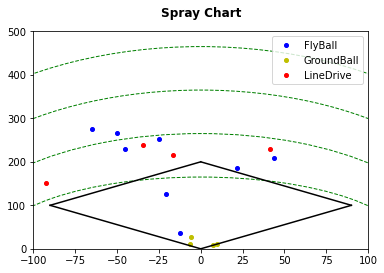

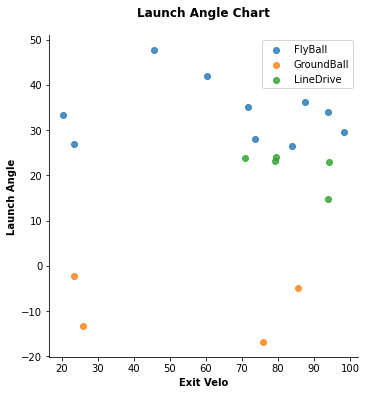

In [77]:
df['field'] = df.apply (lambda row: setBearing(row), axis=1)
batters = df['Batter Name'].unique()
for b in batters:    
    batter_df = df[(df['Batter Name'] == b)]
    hitdf = getHitTypeGroup(batter_df)
    fielddf = getFieldGroup(batter_df)
    totaldf = getTotalGroup(batter_df)
    spray_chart_graph(batter_df)
    create_pitch_graph(batter_df)
    #condense tables into 1
    frames = [hitdf, fielddf, totaldf]
    result = pd.concat(frames)
    idx = result.index.tolist()
    idx.remove('Total')
    final = result.reindex(['Total'] + idx)

    dfi.export(final.style,directory +"mytable" + b +".png")
    # Instantiation of inherited class
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()
    pdf.cell(80)
    # Centered text in a framed 20*10 mm cell and line break
    pdf.set_font('Arial', 'B', 20)
    pdf.cell(36, 10, b, 0, 0, 'C')
    #     pdf.cell(80)
    pdf.set_font('Arial', 'B', 15)
    pdf.cell(-35, 30, 'Created by NPI Sports', 0, 0, 'C')
    pdf.set_font('Arial', '', 10)
    pdf.cell(33, 42, 'www.GoNPI.org/NPI-Sports', 0, 0, 'C')
    # Line break
    pdf.ln(20)
    pdf.image(directory + 'mytable'+ b +'.png', x=45, y=40, w=130, h=50)
    pdf.image(directory + 'spray_chart.png', x=25, y=100, w=75, h=70)
    pdf.image(directory + 'pitch_movements.png', x=115, y=100, w=70, h=75)
    pdf.output(directory + b + '.pdf', 'F')

In [7]:
def setBearing(df):
    if(df.Bearing >= -16.7 and df.Bearing < 16.7):
        field = 'CF'
    elif(df.Bearing < 16.7):
        field = 'LF'
    elif(df.Bearing > 16.7):
        field = 'RF'
    else:
        field = ''
    return field

In [24]:
def getHitTypeGroup(df):
    hitdf = df.groupby(['Hit Type'], as_index=True
        ).agg(
                Total=('Hit Type', 'count'),
                MaxDistance=('Distance (ft)','max'),
                MaxExitVelo=('Exit Speed (mph)','max'),
                AvgExitVelo=('Exit Speed (mph)', 'mean'),
                MedianLA=('Launch Angle', 'median')
        )

    hitdf.MaxDistance = hitdf.MaxDistance.round(2).map("{:3}".format)
    hitdf.MaxExitVelo = hitdf.MaxExitVelo.round(2).map("{:3}".format)
    hitdf.AvgExitVelo = hitdf.AvgExitVelo.round(2).map("{:3}".format)
    hitdf.MedianLA = hitdf.MedianLA.round(2).map("{:3}".format)
    hitdf = hitdf.rename(columns={"MaxDistance": "Max Distance", "MaxExitVelo": "Max Exit Velo", "AvgExitVelo": "Avg. Exit Velo",
                                  "MedianLA": "Median Launch Angle"})
    df1 = pd.DataFrame([[''] * len(hitdf.columns)], columns=hitdf.columns)
    # df1.index.values = ['']
    df1.index = ['']
    finaldf = hitdf.append(df1, ignore_index=False)
    finaldf
    return finaldf

In [37]:
def getFieldGroup(df):
    field_list = []
    left = ''
    center = ''
    right = ''
    fielddf = df.groupby(['field'], as_index=True
        ).agg(
                Total=('Hit Type', 'count'),
                MaxDistance=('Distance (ft)','max'),
                MaxExitVelo=('Exit Speed (mph)','max'),
                AvgExitVelo=('Exit Speed (mph)', 'mean'),
                MedianLA=('Launch Angle', 'median')
        )

    fielddf.MaxDistance = fielddf.MaxDistance.round(2).map("{:3}".format)
    fielddf.MaxExitVelo = fielddf.MaxExitVelo.round(2).map("{:3}".format)
    fielddf.AvgExitVelo = fielddf.AvgExitVelo.round(2).map("{:3}".format)
    fielddf.MedianLA = fielddf.MedianLA.round(2).map("{:3}".format)
    fielddf = fielddf.rename(columns={"MaxDistance": "Max Distance", "MaxExitVelo": "Max Exit Velo", "AvgExitVelo": "Avg. Exit Velo",
                                  "MedianLA": "Median Launch Angle"})
    #drop any empty rows  
    fielddf = fielddf.reindex(['LF', 'CF', 'RF'])
    fielddf = fielddf.drop('', errors='ignore')
    idx = fielddf.index
    #check to add any field that is not in list
    if(idx.isin(['LF']).any()):
        left = True
    if(idx.isin(['CF']).any()):
        center = True
    if(idx.isin(['RF']).any()):
        right = True

    if(left != True):
        field_list.append('LF')
    if(center != True):
        field_list.append('CF')
    if(right != True):
        field_list.append('RF')

    #add empty field row(s)
    for f in field_list:
        fielddf.loc[f] = [0, 0, 0, 0, 0]
    return fielddf

In [9]:
def getTotalGroup(df):
    list_dict = []
    Total = df['Hit Type'].count()
    MaxDistance = df['Distance (ft)'].max()
    MaxExitVelo = df['Exit Speed (mph)'].max()
    AvgExitVelo = df['Exit Speed (mph)'].mean()
    MedianLA = df['Launch Angle'].median()
    list_dict.append({'Total': Total, 'Max Distance': MaxDistance, 'Max Exit Velo': MaxExitVelo, 'Avg. Exit Velo': AvgExitVelo, 
            'Median Launch Angle': MedianLA})
    capdf = pd.DataFrame(list_dict, columns = ['Total', 'Max Distance', 'Max Exit Velo', 'Avg. Exit Velo', 'Median Launch Angle'])
    capdf['Max Distance'] = capdf['Max Distance'].round(2).map("{:3}".format)
    capdf['Max Exit Velo'] = capdf['Max Exit Velo'].round(2).map("{:3}".format)
    capdf['Avg. Exit Velo'] = capdf['Avg. Exit Velo'].round(2).map("{:3}".format)
    capdf['Median Launch Angle'] = capdf['Median Launch Angle'].round(2).map("{:3}".format)
    capdf.index = ['Total']
    return capdf

# capdf

In [70]:
def spray_chart_graph(df):
    fig, ax = plt.subplots()
    plt.xlim([-100, 100])
    plt.ylim([0, 500])
    colors = ['b','y','r','r','k']
    groups = df.groupby('Hit Type')
    i=0
    for name, group in groups:
        ax.plot(group["Distance (ft) [X]"], group["Distance (ft) [Y]"], marker='o', linestyle='', ms=4, label=name, color=colors[i])
        i+=1
    ax.legend(numpoints=1)
    a = matplotlib.patches.Arc((0,0), 250, 330, theta1=0, theta2=360, linestyle = '--', color='g')
    ax.add_patch(a)
    a = matplotlib.patches.Arc((0,0), 300, 530, theta1=0, theta2=360, linestyle = '--', color='g')
    ax.add_patch(a)
    a = matplotlib.patches.Arc((0,0), 350, 730, theta1=0, theta2=360, linestyle = '--', color='g')
    ax.add_patch(a)
    a = matplotlib.patches.Arc((0,0), 400, 930, theta1=0, theta2=360, linestyle = '--', color='g')
    ax.add_patch(a)
    plt.plot([0,90],[0,100], color='black')
    plt.plot([0,-90],[0,100], color='black')
    plt.plot([90,0],[100,200], color='black')
    plt.plot([-90,0],[100,200], color='black')
    plt.title('Spray Chart',fontweight='bold', y=1.04)
    plt.savefig(directory + 'spray_chart.png', bbox_inches="tight")
    plt.show()
    plt.close()

In [67]:
from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        # Logo
        self.image(directory + 'logo.png', 10, 8, 33)
        # Arial bold 15
        self.set_font('Arial', 'B', 15)
        # Move to the right      

    # Page footer
    def footer(self):
        # Position at 1.5 cm from bottom
        self.set_y(-15)
        # Arial italic 8
        self.set_font('Arial', 'I', 8)
        # Page number
        self.cell(0, 10, 'Page ' + str(self.page_no()) + '/{nb}', 0, 0, 'C')

In [74]:
def create_pitch_graph(df):
    sns.lmplot( x="Exit Speed (mph)", y="Launch Angle", data=df, fit_reg=False, hue='Hit Type', legend=False)
    plt.legend(loc='best')
    plt.title('Launch Angle Chart',fontweight='bold', y=1.04)

    plt.xlabel('Exit Velo', fontweight='bold')
    plt.ylabel('Launch Angle', fontweight='bold')
    plt.savefig(directory + 'pitch_movements.png',bbox_inches="tight")
    plt.show()
    plt.close()